# Tasso di letalità

Tasso di letalità istantaneo ponderato (wiCFR) per COVID-19 in Italia.

> Max Pierini, Alessio Pamovio, Sandra Mazzoli

***

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.integrate import quad
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import dates as mdates
import statsmodels.api as sm
#import missingno as msno

from tqdm.notebook import tqdm

from IPython.display import Markdown, Latex, clear_output

In [2]:
display(Markdown(fr"""
Case Fatality Rate (CFR) is usually estimated as total death over total cases.
This estimate though does not take into account likely dynamic variations of fatality
along the time line.
Is here presented a dynamic estimation of instant case fatality rate based upon onset-to-death interval:
weighted instant Case Fatality Rate (wiCFR).
"""))


Case Fatality Rate (CFR) is usually estimated as total death over total cases.
This estimate though does not take into account likely dynamic variations of fatality
along the time line.
Is here presented a dynamic estimation of instant case fatality rate based upon onset-to-death interval:
weighted instant Case Fatality Rate (wiCFR).


METODO (preprint):

Massimo Pierini, Sandra Mazzoli, & Alessio Pamovio. (2020, November 3). Estimation of weighted instant Case Fatality Rate of COVID-19 in Italy. Zenodo. http://doi.org/10.5281/zenodo.4235485

***

In [3]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')

In [4]:
def shape_rate_from_mu_cv(mu, cv):
    """
    Calculate shape and rate for a Gamma distribution
    given mean (mu) and coefficient of variation (cv).
    
    Args:
        mu (float) : mean of gamma distribution
        cv (float) : coefficient of variation
        
    Returns:
        A tuple of shape and rate of the
        gamma distribution (scale = 1/rate).
    """
    sd = mu * cv
    shape = mu ** 2 / sd ** 2
    rate = mu / sd ** 2
    
    return (shape, rate)

In [5]:
days = np.linspace(0, 60, 61)

In [6]:
sh, ra = shape_rate_from_mu_cv(18.8, .45)

In [7]:
onset_to_death_dist = sps.gamma(a=sh, scale=1/ra)
onset_to_death = onset_to_death_dist.pdf(days)
onset_to_death /= onset_to_death.sum()

In [8]:
otd_df = pd.DataFrame({'days': days, 'PDF': onset_to_death})

In [9]:
alpha = .05

In [10]:
otd_md = onset_to_death_dist.ppf(.5)
otd_ci_lo = onset_to_death_dist.ppf(alpha/2)
otd_ci_hi = onset_to_death_dist.ppf(1-alpha/2)

In [11]:
otd_mo = onset_to_death.argmax()

In [12]:
otd_iqr25, otd_iqr75 = onset_to_death_dist.interval(.5)

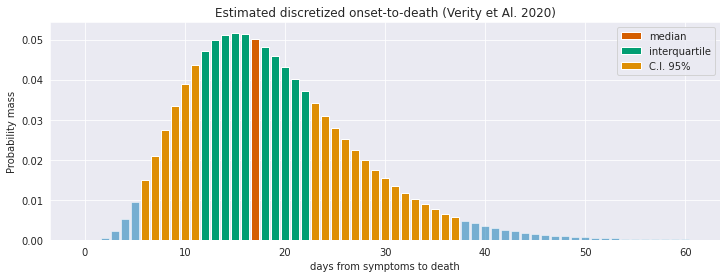

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(days, onset_to_death, alpha=.5)

ax.bar(
    range(int(otd_ci_lo), int(otd_ci_hi)), 
    onset_to_death[int(otd_ci_lo):int(otd_ci_hi)], 
    label=f'C.I. {1-alpha:.0%}'
)

ax.bar(
    range(int(otd_iqr25), int(otd_iqr75)), 
    onset_to_death[int(otd_iqr25):int(otd_iqr75)], 
    label='interquartile'
)

ax.bar(int(otd_md), onset_to_death[int(otd_md)], label='median')

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

ax.set_xlabel('days from symptoms to death')
ax.set_ylabel('Probability mass')
ax.set_title('Estimated discretized onset-to-death (Verity et Al. 2020)')
plt.show()

In [14]:
df = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    index_col='data', parse_dates=['data']
).sort_values('data')

In [15]:
df['nuovi_deceduti'] = df.deceduti.diff()

In [16]:
def ecdf(data, weights=None):
    """
    Compute estimated CDF for one-dimensional
    array of data.
    """
    
    n = len(data)
    i = np.argsort(data)
    x = data[i]
    y = np.arange(1, n+1) / n
    
    if weights is not None:
        w = weights[i]
    
    return (x, y, weights)

In [17]:
check_days = range(df.index.size)

CFR = {
    'date': [],
    'median': [],
    'Q1': [],
    'Q3': [],
    'lo': [],
    'hi': [],
}

for check_day_inv in check_days:
    if not check_day_inv:
        continue
    check_day = -check_day_inv
    _CFR = []
    stop = False
    for day in days:
    
        try:
            day_one = df.index[check_day]
            day_idx = df.index[check_day-int(day)]

            pos = df.loc[day_idx]['nuovi_positivi']
            dec = df.loc[day_one]['nuovi_deceduti']

            _CFR.append(dec / pos)
        except Exception as err:
            #print(day_one.date())
            #print(err)
            stop = True
            break
    if stop:
        break
        
    _CFR = np.array(_CFR)
    _ = """
    CFR_x = np.linspace(0, _CFR.max(), 100)
    try:
        CFR_dist = sps.gaussian_kde(_CFR, weights=onset_to_death[:_CFR.size])
    except Exception as err:
        print(err)
        print(_CFR.size)
        print(onset_to_death[:int(day)+1].size)
    CFR_y = CFR_dist.pdf(CFR_x)
    CFR_y /= CFR_y.sum()
    CFR_sample = CFR_dist.resample(int(1e6), seed=1976)"""
    
    CFR_sample = np.random.choice(_CFR, size=1000000, p=onset_to_death)
    CFR_median = np.median(CFR_sample)
    CFR_q1 = np.percentile(CFR_sample, 25) 
    CFR_q3 = np.percentile(CFR_sample, 75)
    CFR_lo = np.percentile(CFR_sample, 100*alpha/2)
    CFR_hi = np.percentile(CFR_sample, 100-100*alpha/2)
    
    CFR['date'].append(pd.to_datetime(day_one.date()))
    CFR['median'].append(CFR_median)
    CFR['Q1'].append(CFR_q1)
    CFR['Q3'].append(CFR_q3)
    CFR['lo'].append(CFR_lo)
    CFR['hi'].append(CFR_hi)

# Grezzo

In [18]:
cfr_df = pd.DataFrame(CFR).sort_values(by='date', ignore_index=True)
cfr_df = cfr_df.set_index('date')

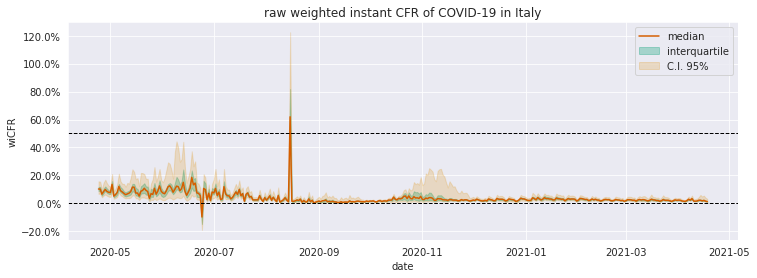

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))

g = sns.lineplot(data=cfr_df, x='date', y='median', color='C3', ax=ax, label='median')

g.fill_between(
    cfr_df.index,
    cfr_df.Q1, cfr_df.Q3,
    alpha=.3, label='interquartile',
    color='C2'
)
g.fill_between(
    cfr_df.index,
    cfr_df.lo, cfr_df.hi,
    alpha=.2, label=f'C.I. {1-alpha:.0%}',
    color='C1'
)
g.axhline(0, ls='--', lw=1, color='k')
g.axhline(0.5, ls='--', lw=1, color='k')

g.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
g.set_ylabel('wiCFR')
g.set_xlabel('date')
g.set_title('raw weighted instant CFR of COVID-19 in Italy')
g.legend()
plt.show()

# Filtrato

In [20]:
def filter_min_max(df, col, win=7, func=np.mean, fmin=0, fmax=1):
    """
    Filter outliers less than fmin or greater than fmax, then
    impute to the values the func estimate on a win window.
    
    Args:
        df
        col
        win
        func
        fmin
        fmax
        
    Returns:
        A pandas dataframe with filtered and imputed outliers.
    """
    where = (df[col]<fmin) | (df[col]>fmax)
    idxs = np.argwhere(where.to_numpy()).flatten()
    print(f"OUTLIERS in col {col} ({fmin}< or >{fmax})")
    print("========================================")
    print(df[where])
    _df = df.copy(deep=True)
    print(f"\nImpute function `{func.__name__}`, window {win}")
    print("========================================")
    for idx in idxs:
        win_lo = int(idx-win/2)
        win_hi = int(idx+win/2)
        _df.iloc[idx] = func(_df.iloc[win_lo:win_hi])
    print(_df[where])
    return _df

In [21]:
cfr_filtered = filter_min_max(cfr_df, 'median', fmin=0, fmax=.5)

OUTLIERS in col median (0< or >0.5)
              median        Q1        Q3        lo        hi
date                                                        
2020-06-24 -0.097484 -0.147619 -0.078086 -0.190184 -0.038653
2020-08-15  0.619608  0.516340  0.818653  0.286232  1.224806

Impute function `mean`, window 7
              median        Q1        Q3        lo        hi
date                                                        
2020-06-24  0.065129  0.036507  0.093421  0.004055  0.150482
2020-08-15  0.107225  0.089007  0.141138  0.051793  0.211517


In [22]:
cfr_tot = pd.merge(cfr_df, cfr_filtered, on=cfr_df.index, suffixes=['_raw', '_filtered'])

In [23]:
cfr_tot.key_0 = pd.to_datetime(cfr_tot.key_0)

cfr_cum = pd.DataFrame(df.deceduti / df.totale_casi)

cfr_com = pd.merge_asof(cfr_cum, cfr_tot, right_on='key_0', left_on=cfr_cum.index)

In [24]:
cfr_cols = list(cfr_com.columns)

In [25]:
cfr_cols[0] = 'cfr_cum'

In [26]:
cfr_com.columns = cfr_cols

cfr_com.set_index('key_0', inplace=True)

cfr_com.index = pd.to_datetime(cfr_com.index.date)

cfr_com.index.name = 'date'

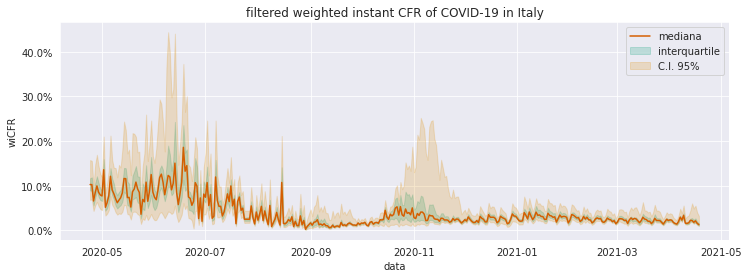

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

g = sns.lineplot(data=cfr_com, x='date', y='median_filtered', color='C3', ax=ax, label='mediana')

g.fill_between(
    cfr_com.index,
    cfr_com.Q1_filtered, cfr_com.Q3_filtered,
    alpha=.2, label='interquartile',
    color='C2'
)
g.fill_between(
    cfr_com.index,
    cfr_com.lo_filtered, cfr_com.hi_filtered,
    alpha=.2, label=f'C.I. {1-alpha:.0%}',
    color='C1'
)
g.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
g.set_ylabel('wiCFR')
g.set_xlabel('data')
g.set_title('filtered weighted instant CFR of COVID-19 in Italy')
g.legend()
plt.show()

# Mediana settimanale

In [28]:
_ = """cfr_com['week'] = cfr_com.index.isocalendar().week.astype(int)

cfr_com_nona = cfr_com.dropna(subset=['median_raw'])

cfr_week = cfr_com_nona.groupby('week').median()

cfr_week['date'] = cfr_com_nona.reset_index().groupby('week')['date'].max()"""

In [29]:
cfr_week = cfr_com.resample('W', label='left').median().reset_index()

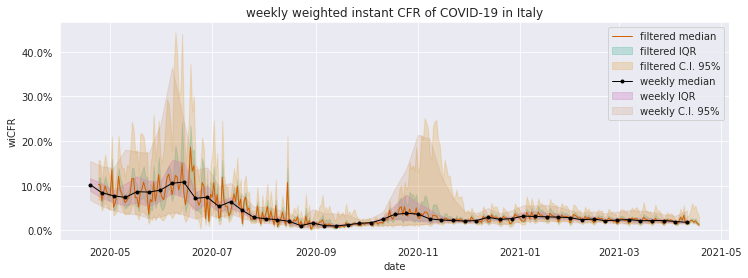

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))

g = sns.lineplot(
    data=cfr_com, 
    x='date', 
    y='median_filtered', 
    color='C3', ax=ax, lw=1, label='filtered median'
)
g.fill_between(
    cfr_com.index,
    cfr_com.Q1_filtered, cfr_com.Q3_filtered,
    alpha=.2, label='filtered IQR',
    color='C2'
)
g.fill_between(
    cfr_com.index,
    cfr_com.lo_filtered, cfr_com.hi_filtered,
    alpha=.2, label=f'filtered C.I. {1-alpha:.0%}',
    color='C1'
)

g.plot(
    cfr_week['date'], cfr_week.median_raw,
    lw=1, color='k', marker='.',
    label='weekly median'
)
g.fill_between(
    cfr_week['date'],
    cfr_week.Q1_raw, cfr_week.Q3_raw, 
    color='C4', alpha=.3,
    label='weekly IQR'
)
g.fill_between(
    cfr_week['date'],
    cfr_week.lo_raw, cfr_week.hi_raw, 
    color='C5', alpha=.2,
    label=f'weekly C.I. {1-alpha:.0%}',
)

g.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
g.set_ylabel('wiCFR')
g.set_xlabel('date')
g.set_title('weekly weighted instant CFR of COVID-19 in Italy')

handles, labels = g.get_legend_handles_labels()
order = [0,2,3,1,4,5]
_labels = [labels[i] for i in order]
_handles = [handles[i] for i in order]
g.legend(_handles, _labels)

plt.show()

# Confronto con cumulativo

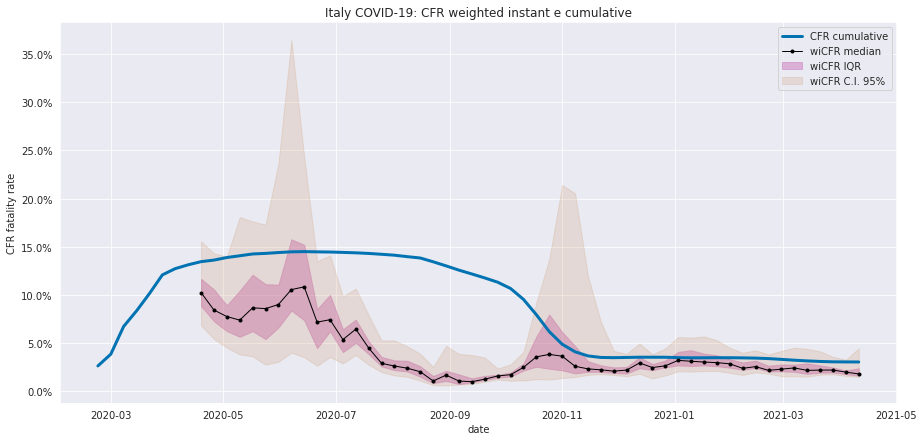

In [31]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.lineplot(
    data=cfr_week,
    x='date', y='cfr_cum',
    label='CFR cumulative',
    lw=3,
    ax=ax
)

g.plot(
    cfr_week['date'], cfr_week.median_raw,
    lw=1, color='k', marker='.',
    label='wiCFR median'
)

cfr_week_ok = cfr_week.dropna(subset=['median_raw'])
g.fill_between(
    cfr_week['date'],
    cfr_week.Q1_raw, cfr_week.Q3_raw, 
    color='C4', alpha=.5,
    label='wiCFR IQR'
)
g.fill_between(
    cfr_week_ok['date'],
    cfr_week_ok.lo_raw, cfr_week_ok.hi_raw, 
    color='C5', alpha=.2,
    label=f'wiCFR C.I. {1-alpha:.0%}'
)
g.set_ylabel('CFR fatality rate')
g.legend()
g.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
g.set_title('Italy COVID-19: CFR weighted instant e cumulative')
plt.show()

In [32]:
last_week = cfr_com[['cfr_cum', 'median_raw']].iloc[-14:] * 100
last_week.columns = ['CFRcum %', 'wiCFR %']
last_week

,CFRcum %,wiCFR %
date,,
2021-04-05,3.026031,1.388693
2021-04-06,3.031079,1.975135
2021-04-07,3.036813,2.941590
2021-04-08,3.035855,2.284776
2021-04-09,3.039695,3.368520
2021-04-10,3.034647,1.613887
2021-04-11,3.030760,1.556402
2021-04-12,3.032389,1.683359
2021-04-13,3.034195,2.238209


# Mediana mensile

In [33]:
cfr_com['month_num'] = [int(f"{y}{m}") for y, m in zip(cfr_com.index.year, cfr_com.index.month)]

In [34]:
cfr_com['month'] = [
    f"{y}\n{m}" for y, m in zip(cfr_com.index.year, cfr_com.index.month_name())]

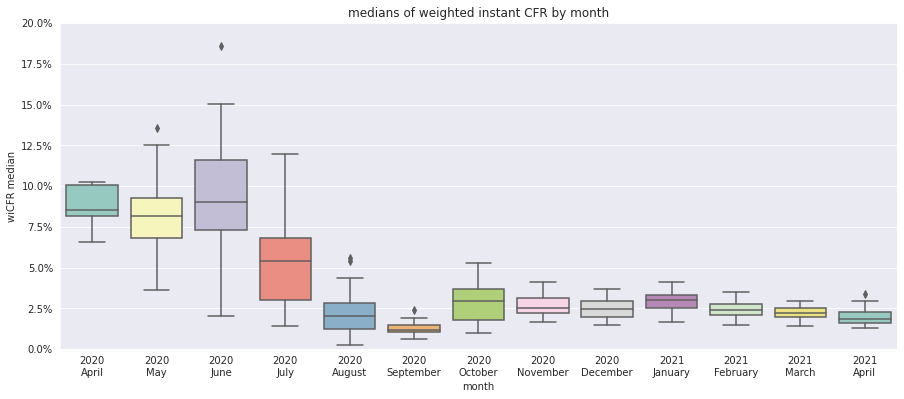

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.boxplot(
    data=cfr_com[~cfr_com.median_raw.isna()],
    x='month', y='median_raw',
    palette="Set3",
    dodge=False,
    ax=ax,
)

g.set(
    title='medians of weighted instant CFR by month',
    ylabel='wiCFR median',
    xlabel='month',
    ylim=(0, .2)
)
g.yaxis.set_major_formatter(mtick.PercentFormatter(1,1))
plt.show()

***